In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob

In [20]:
# read profiles
profile_jsons = glob.glob('*_profile.json')

In [21]:
dfs = [pd.read_json(js) for js in profile_jsons]

In [22]:
# merge dataframes
df = pd.concat(dfs)

In [13]:
df

,bs,n_experts,tp_size,kernel_dur_ms,model_dur_ms
0,1,1,2,459.499512,14703.984375
1,2,1,2,461.465607,14766.899414
2,4,1,2,464.793587,14873.394775
3,8,1,2,468.490257,14991.688232
4,16,1,2,468.131828,14980.218506
...,...,...,...,...,...
13,1024,6,8,606.238708,19399.638672
14,1536,6,8,837.898254,26812.744141
15,2048,6,8,1138.769913,36440.637207
16,3072,6,8,1577.256927,50472.221680


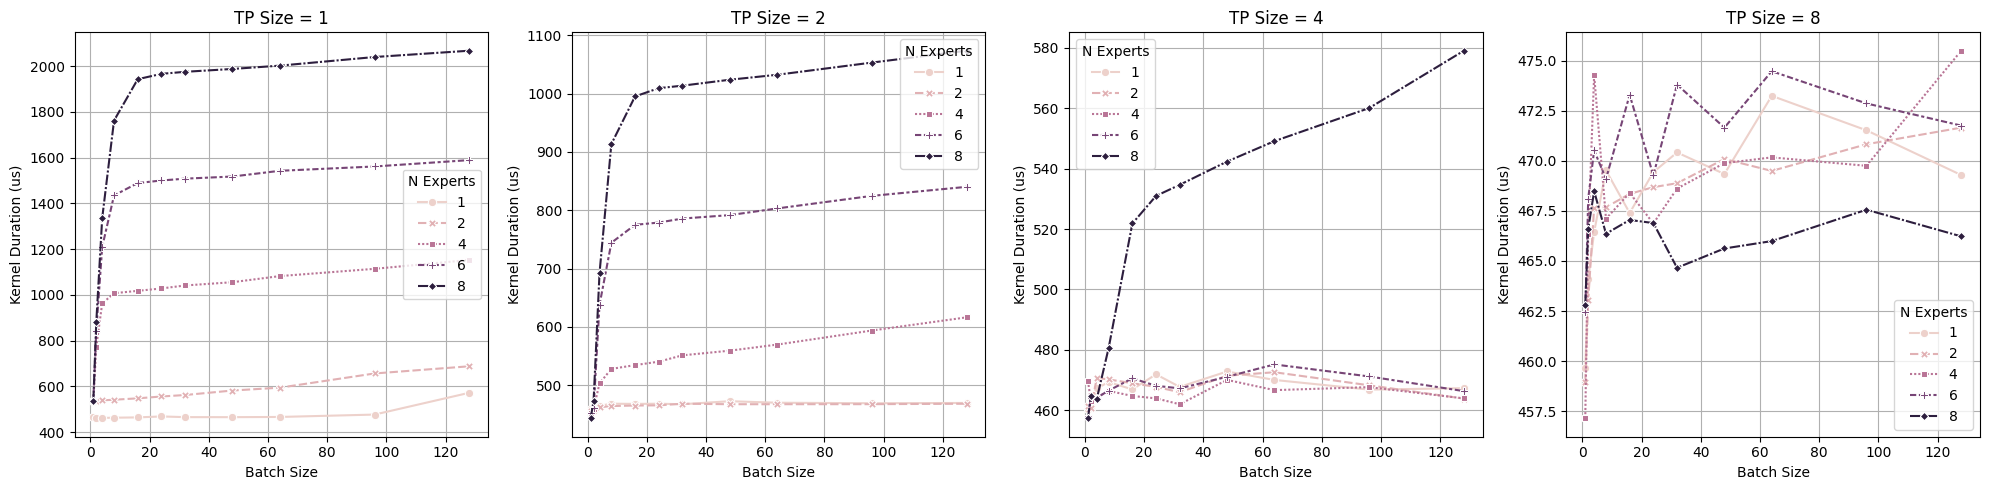

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    tp_size = 2 ** i
    sns.lineplot(x="bs", y="kernel_dur_ms", hue="n_experts", style="n_experts", markers=True, data=df[(df.tp_size == tp_size) & (df.bs <= 128)], ax=ax)
    ax.set_title(f"TP Size = {tp_size}")
    # ax.set_xscale('log')
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Kernel Duration (us)")
    ax.legend(title="N Experts")
    ax.grid()
plt.tight_layout()

In [15]:
fig.savefig("kernel_duration.png", bbox_inches='tight')

In [23]:
# throughput calculation, adjusting for the number of devices
df["bs"] = df["bs"] * (8 / df.tp_size)
df['throughput'] = (df.bs / (df.kernel_dur_ms / 1000)) * 1000 # * (8 / df.tp_size)

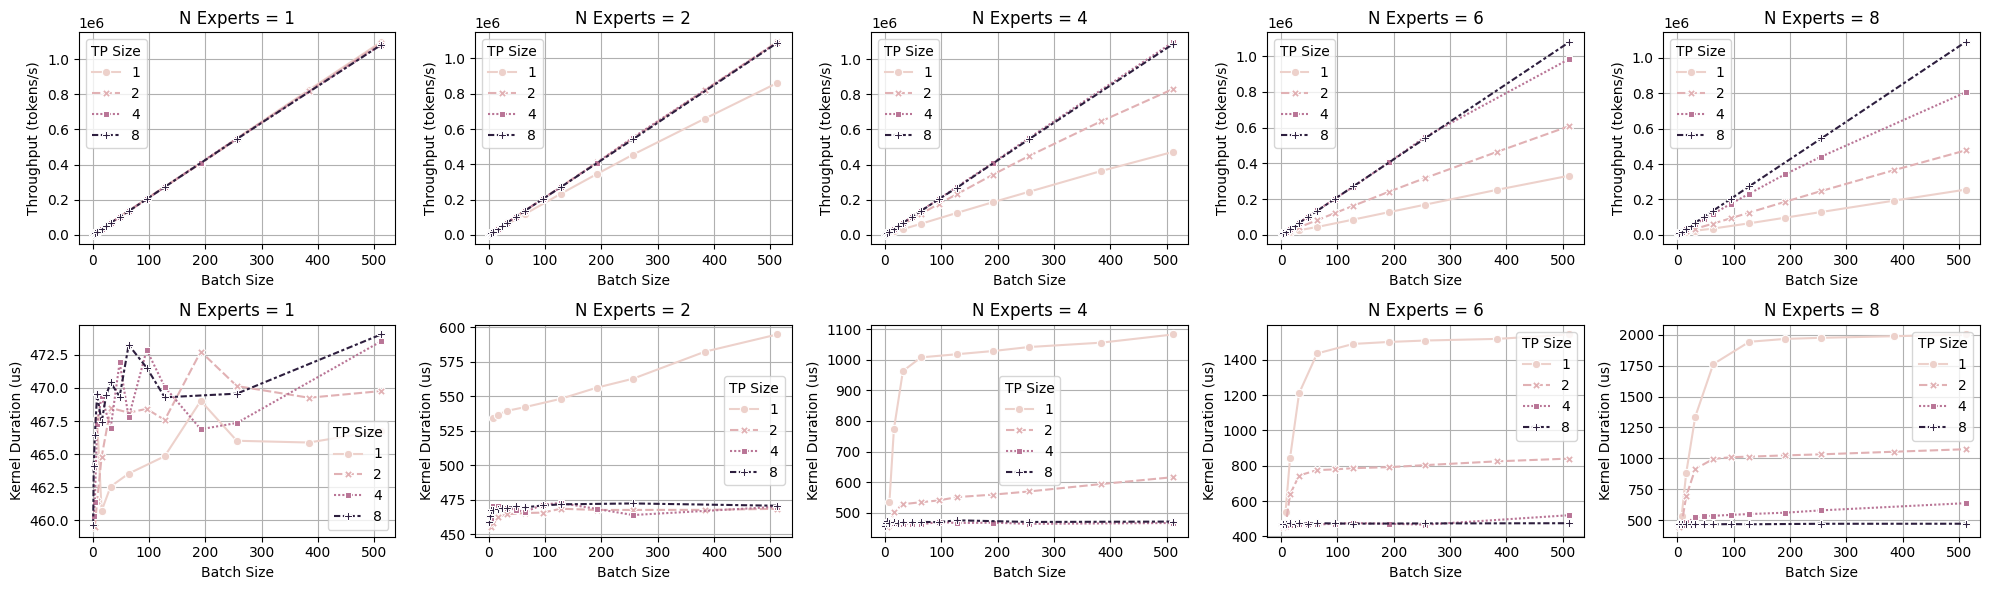

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
for i, ax in enumerate(axes[0, :]):
    n_experts = i * 2 if i > 0 else 1
    sns.lineplot(x="bs", y="throughput", hue="tp_size", style="tp_size", markers=True, data=df[(df.n_experts == n_experts) & (df.bs <= 128)], ax=ax)
    ax.set_title(f"N Experts = {n_experts}")
    # ax.set_xscale('log')
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Throughput (tokens/s)")
    ax.legend(title="TP Size")
    ax.grid()

for i, ax in enumerate(axes[1, :]):
    n_experts = i * 2 if i > 0 else 1
    sns.lineplot(x="bs", y="kernel_dur_ms", hue="tp_size", style="tp_size", markers=True, data=df[(df.n_experts == n_experts) & (df.bs <= 128)], ax=ax)
    ax.set_title(f"N Experts = {n_experts}")
    # ax.set_xscale('log')
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Kernel Duration (us)")
    ax.legend(title="TP Size")
    ax.grid()
plt.tight_layout()

In [ ]:
fig.savefig("kernel_throughput_dp_weak_scaling.pdf", bbox_inches='tight')

In [6]:
# compare tp vs ep, ignoring communication
dfs = []
for tp_degree in [1, 2, 4, 8]:
    ep_degree = 8 // tp_degree
    n_experts = tp_degree
    this_df = df[(df.n_experts == n_experts) & (df.tp_size == tp_degree)].copy()
    # here bs = total bs processed by all devices
    # assume tokens equally partitioned across ep ranks,
    # we need to adjust bs to reflect the total bs processed by all devices
    this_df['bs'] = this_df['bs'] * ep_degree
    dfs.append(this_df)

filtered_df = pd.concat(dfs)

In [7]:
filtered_df

,bs,n_experts,tp_size,kernel_dur_ms,model_dur_ms
0,8,1,1,467.671051,14965.473633
1,16,1,1,460.728302,14743.305664
2,32,1,1,462.561264,14801.960449
3,64,1,1,463.534088,14833.090820
4,128,1,1,464.844818,14875.034180
...,...,...,...,...,...
13,1024,8,8,614.307823,19657.850342
14,1536,8,8,831.877136,26620.068359
15,2048,8,8,1072.209930,34310.717773
16,3072,8,8,1532.948456,49054.350586


In [8]:
filtered_df["throughput"] = (filtered_df.bs / (filtered_df.kernel_dur_ms / 1000)) * 1000

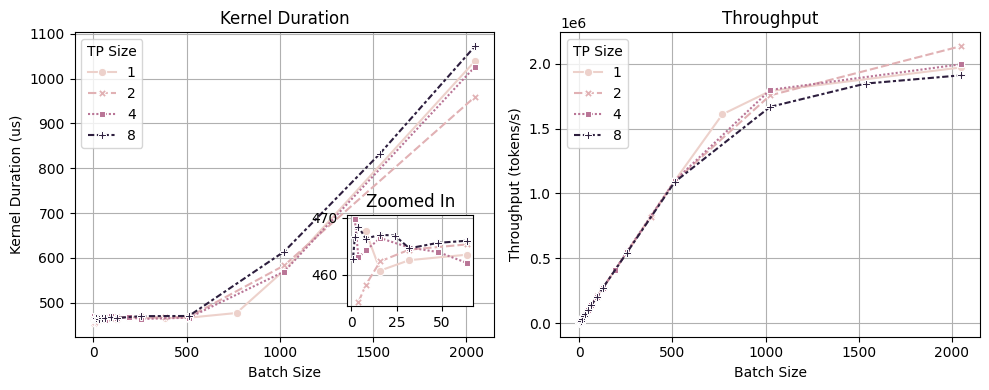

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# latency plot
ax0 = sns.lineplot(x="bs", y="kernel_dur_ms", hue="tp_size", style="tp_size", markers=True, data=filtered_df[(filtered_df.bs <= 2048)], ax=ax[0])
ax0.set_title(f"Kernel Duration")
ax0.set_xlabel("Batch Size")
ax0.set_ylabel("Kernel Duration (us)")
ax0.legend(title="TP Size")
ax0.grid()
# add a zoomed in version
ax0sub = ax0.inset_axes([0.65, 0.1, 0.3, 0.3])
sns.lineplot(x="bs", y="kernel_dur_ms", hue="tp_size", style="tp_size", markers=True, data=filtered_df[(filtered_df.bs <= 64)], ax=ax0sub, legend=False)
ax0sub.set_title("Zoomed In")
ax0sub.xaxis.get_label().set_visible(False)
ax0sub.yaxis.get_label().set_visible(False)
# ax0sub.set_xlabel("Batch Size")
# ax0sub.set_ylabel("Kernel Duration (us)")
# ax0sub.legend(title="TP Size")
ax0sub.grid()

# throughput plot
ax1 = sns.lineplot(x="bs", y="throughput", hue="tp_size", style="tp_size", markers=True, data=filtered_df[(filtered_df.bs <= 2048)], ax=ax[1])
ax1.set_title(f"Throughput")
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Throughput (tokens/s)")
ax1.legend(title="TP Size")
ax1.grid()
# add a zoomed in version
# ax1sub = ax1.inset_axes([0.65, 0.1, 0.3, 0.3])
# sns.lineplot(x="bs", y="throughput", hue="tp_size", style="tp_size", markers=True, data=filtered_df[(filtered_df.bs <= 64)], ax=ax1sub, legend=False)
# ax1sub.set_title("Zoomed In")
# ax1sub.xaxis.get_label().set_visible(False)
# ax1sub.yaxis.get_label().set_visible(False)
# ax1sub.grid()

plt.tight_layout()

In [10]:
fig.savefig("tp_vs_ep.pdf", bbox_inches='tight')